In [127]:
import sys
sys.path.append("../")

import numpy as onp
import matplotlib.pyplot as plt
from modules.cosmopower_jax import CosmoPowerJAX as CPJ

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load emulators

In [128]:
emulator_custom_TT = CPJ(probe='custom_log', filename='cmb_neff_spt_TT_NN.pkl')
emulator_custom_TE = CPJ(probe='custom_pca', filename='cmb_neff_spt_TE_PCAplusNN.pkl')
emulator_custom_EE = CPJ(probe='custom_log', filename='cmb_neff_spt_EE_NN.pkl')

In [129]:
cosmo_params_custom1 = onp.array([
    0.021,  # ombh2
    0.1,   # omch2
    0.64,   # h
    0.066,   # tau
    0.965,  # ns
    3.1,    # logA
    2.99    # neff
])

cosmo_params_custom2 = onp.array([
    0.023,  # ombh2
    0.12,   # omch2
    0.80,   # h
    0.07,   # tau
    0.965,  # ns
    3.1,    # logA
    3.2    # neff
])

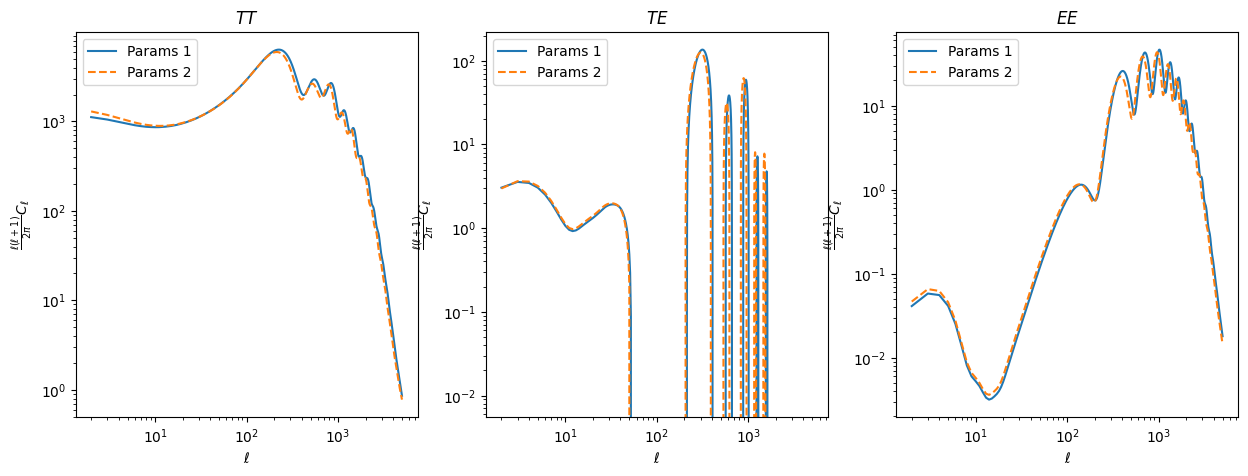

In [130]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

ell = emulator_custom_TT.modes
axs[0].plot(ell, emulator_custom_TT.predict(cosmo_params_custom1) * ell * ( ell + 1) / (2 * onp.pi), label="Params 1")
axs[0].plot(ell, emulator_custom_TT.predict(cosmo_params_custom2) * ell * ( ell + 1) / (2 * onp.pi), ls='--', label="Params 2")
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel('$\ell$')
axs[0].set_ylabel('$\\frac{\ell(\ell+1)}{2 \pi} C_\ell$')
axs[0].set_title("$TT$")
axs[0].legend()

ell = emulator_custom_TE.modes
axs[1].plot(ell, emulator_custom_TE.predict(cosmo_params_custom1) * ell * ( ell + 1) / (2 * onp.pi), label="Params 1")
axs[1].plot(ell, emulator_custom_TE.predict(cosmo_params_custom2) * ell * ( ell + 1) / (2 * onp.pi), ls='--', label="Params 2")

axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel('$\ell$')
axs[1].set_ylabel('$\\frac{\ell(\ell+1)}{2 \pi} C_\ell$')
axs[1].set_title("$TE$")
axs[1].legend()

ell = emulator_custom_EE.modes
axs[2].plot(ell, emulator_custom_EE.predict(cosmo_params_custom1) * ell * ( ell + 1) / (2 * onp.pi), label="Params 1")
axs[2].plot(ell, emulator_custom_EE.predict(cosmo_params_custom2) * ell * ( ell + 1) / (2 * onp.pi), ls='--', label="Params 2")

axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_xlabel('$\ell$')
axs[2].set_ylabel('$\\frac{\ell(\ell+1)}{2 \pi} C_\ell$')
axs[2].set_title("$EE$")
axs[2].legend()

Test gradients of the emulator.

In [131]:
import jax
import jax.numpy as np

# Dummy scalar function to test grads
def test_fn(params):
    return np.sum(emulator_custom_TE.predict(params))
    

# Test grad
jax.grad(test_fn)(cosmo_params_custom1)  # Works!

Array([ 8.7357819e+01,  1.6922811e+00, -3.1814549e+00,  8.6163559e+01,
       -4.1212051e+01,  7.2206669e+00, -5.0315730e-02], dtype=float32)

In [132]:
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

from likelihoods.planck2018_lite.likelihood import PlanckLiteJax
import jax.numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
# Planck2018
cosmo_params_planck = np.array([
    0.0224,  # ombh2
    0.12,   # omch2
    0.7,   # h
    0.0543,   # tau
    0.966,  # ns
    3.0448,    # logA
    3.048    # neff
])

In [134]:

ell = emulator_custom_TT.modes

Dltt = emulator_custom_TT.predict(cosmo_params_planck) * ell * (ell + 1) / (2 * np.pi)
Dlte = emulator_custom_TE.predict(cosmo_params_planck) * ell * (ell + 1) / (2 * np.pi)
Dlee = emulator_custom_EE.predict(cosmo_params_planck) * ell * (ell + 1) / (2 * np.pi)

# Convert to jax.numpy

Dltt = np.array(Dltt)
Dlte = np.array(Dlte)
Dlee = np.array(Dlee)

ellmin = int(ell[0]) 

plite = PlanckLiteJax(year=2018, spectra="TTTEEE", ellmin=ellmin, use_low_ell_bins=False, data_directory='../likelihoods/planck2018_lite/data')

loglikelihood = plite.loglike(Dltt[:2507], Dlte[:2507], Dlee[:2507])
loglikelihood

Array(-666.15643, dtype=float32)

Compare with $C_\ell$ from Boltzmann code.

In [135]:
ell, Dltt, Dlte, Dlee = onp.genfromtxt("../../planck-lite-py/data/Dl_planck2015fit.dat", unpack=True)
ellmin = int(ell[0]) 
loglikelihood = plite.loglike(Dltt, Dlte, Dlee)
loglikelihood

Array(-291.33505, dtype=float32)

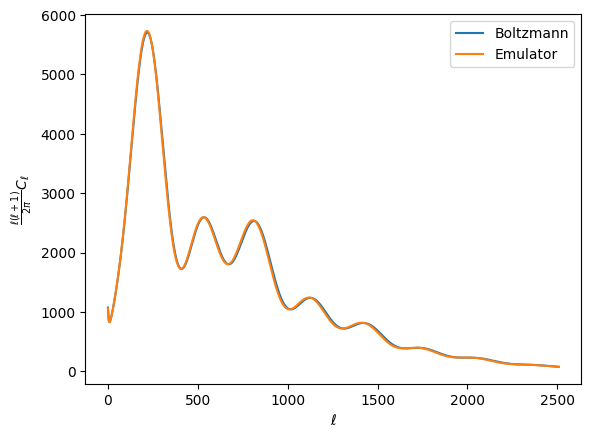

In [136]:
ell, Dltt, Dlte, Dlee = onp.genfromtxt("../../planck-lite-py/data/Dl_planck2015fit.dat", unpack=True)

plt.plot(ell, Dltt, label="Boltzmann")
ell = emulator_custom_TT.modes
plt.plot(ell[:2507], (emulator_custom_TT.predict(cosmo_params_planck) * ell * ( ell + 1) / (2 * np.pi))[:2507], label="Emulator")

plt.xlabel('$\ell$')
plt.ylabel('$\\frac{\ell(\ell+1)}{2 \pi} C_\ell$')

plt.legend()

Look at ratio. NOTE: Parameters don't match exactly.

Text(0, 0.5, 'Ratio')

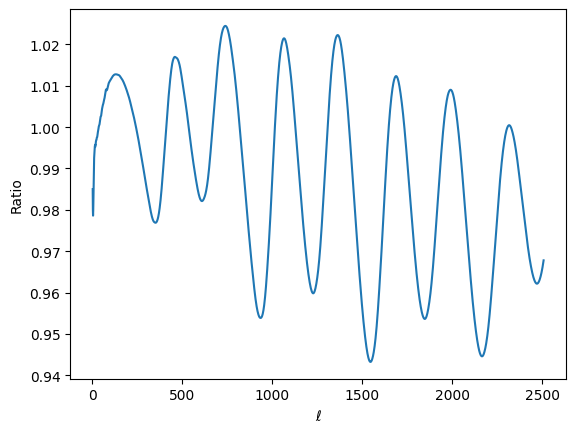

In [137]:
plt.plot(ell[:2507], (emulator_custom_TT.predict(cosmo_params_planck) * ell * ( ell + 1) / (2 * np.pi))[:2507] / Dltt, label="Params 1")
plt.xlabel('$\ell$')
plt.ylabel('Ratio')

## Variational inference

In [138]:
plite = PlanckLiteJax(year=2018, spectra="TTTEEE", use_low_ell_bins=True, ellmin=ellmin, data_directory='../likelihoods/planck2018_lite/data')

def loglike(params):
    """ Emulation + log-likelihood wrapper
    """
    ell = emulator_custom_TT.modes
    Dltt = emulator_custom_TT.predict(params) * ell * (ell + 1) / (2 * np.pi)
    Dlte = emulator_custom_TE.predict(params) * ell * (ell + 1) / (2 * np.pi)
    Dlee = emulator_custom_EE.predict(params) * ell * (ell + 1) / (2 * np.pi)
    return plite.loglike(Dltt, Dlte, Dlee)


In [139]:
# Planck 2018
cosmo_params_planck = np.array([
    0.0224,  # ombh2
    0.12,   # omch2
    0.7,   # h
    0.0543,   # tau
    0.966,  # ns
    3.0448,    # logA
    3.048    # neff
])

loglike(cosmo_params_planck)

Array(-668.5523, dtype=float32)

In [140]:
jax.grad(loglike)(cosmo_params_custom1)

Array([-781723.1  ,  871300.94 ,  148885.05 ,  137993.66 ,   -9251.135,
        -68133.46 ,  -16669.932], dtype=float32)

In [141]:
%%timeit 
loglike(cosmo_params_planck)

2.87 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, autoguide
import optax

In [143]:
def model():
    """ NumPyro model
    """
    ombh2 = numpyro.sample('ombh2', dist.Uniform(0.005, 0.05))
    omch2 = numpyro.sample('omch2', dist.Uniform(0.001, 0.2))
    h = numpyro.sample('h', dist.Uniform(0.5, 0.8))
    ns = numpyro.sample('ns', dist.Uniform(0.8, 1.2))
    logA = numpyro.sample('logA', dist.Uniform(2.7, 4))
    neff = numpyro.sample('neff', dist.Uniform(2., 4.))
    tau = numpyro.sample('tau', dist.TruncatedDistribution(dist.Normal(0.067, 0.023), low=1e-4, high=0.15))

    log_like = loglike(np.array([ombh2, omch2, h, tau, ns, logA, neff]))

    return numpyro.factor('log_like', log_like)


In [144]:
n_steps = 30000
lr = 8e-4

rng = jax.random.PRNGKey(42)
guide = autoguide.AutoIAFNormal(model, num_flows=4, hidden_dims=[64,64],)
optimizer = optim.optax_to_numpyro(optax.adamw(lr))


In [145]:
svi = SVI(model, guide, optimizer, Trace_ELBO(num_particles=16),)
svi_results = svi.run(rng, n_steps)

100%|██████████| 30000/30000 [05:38<00:00, 88.68it/s, init loss: 491916.2500, avg. loss [28501-30000]: 318.5913]


In [154]:
# Make dict of Planck 2018 params
params = {
    'ombh2': 0.022383,
    'omch2': 0.12011,
    'h': 0.6732,
    'tau': 0.0543,
    'ns': 0.96605,
    'logA': 3.0448,
    'neff': 2.92
}

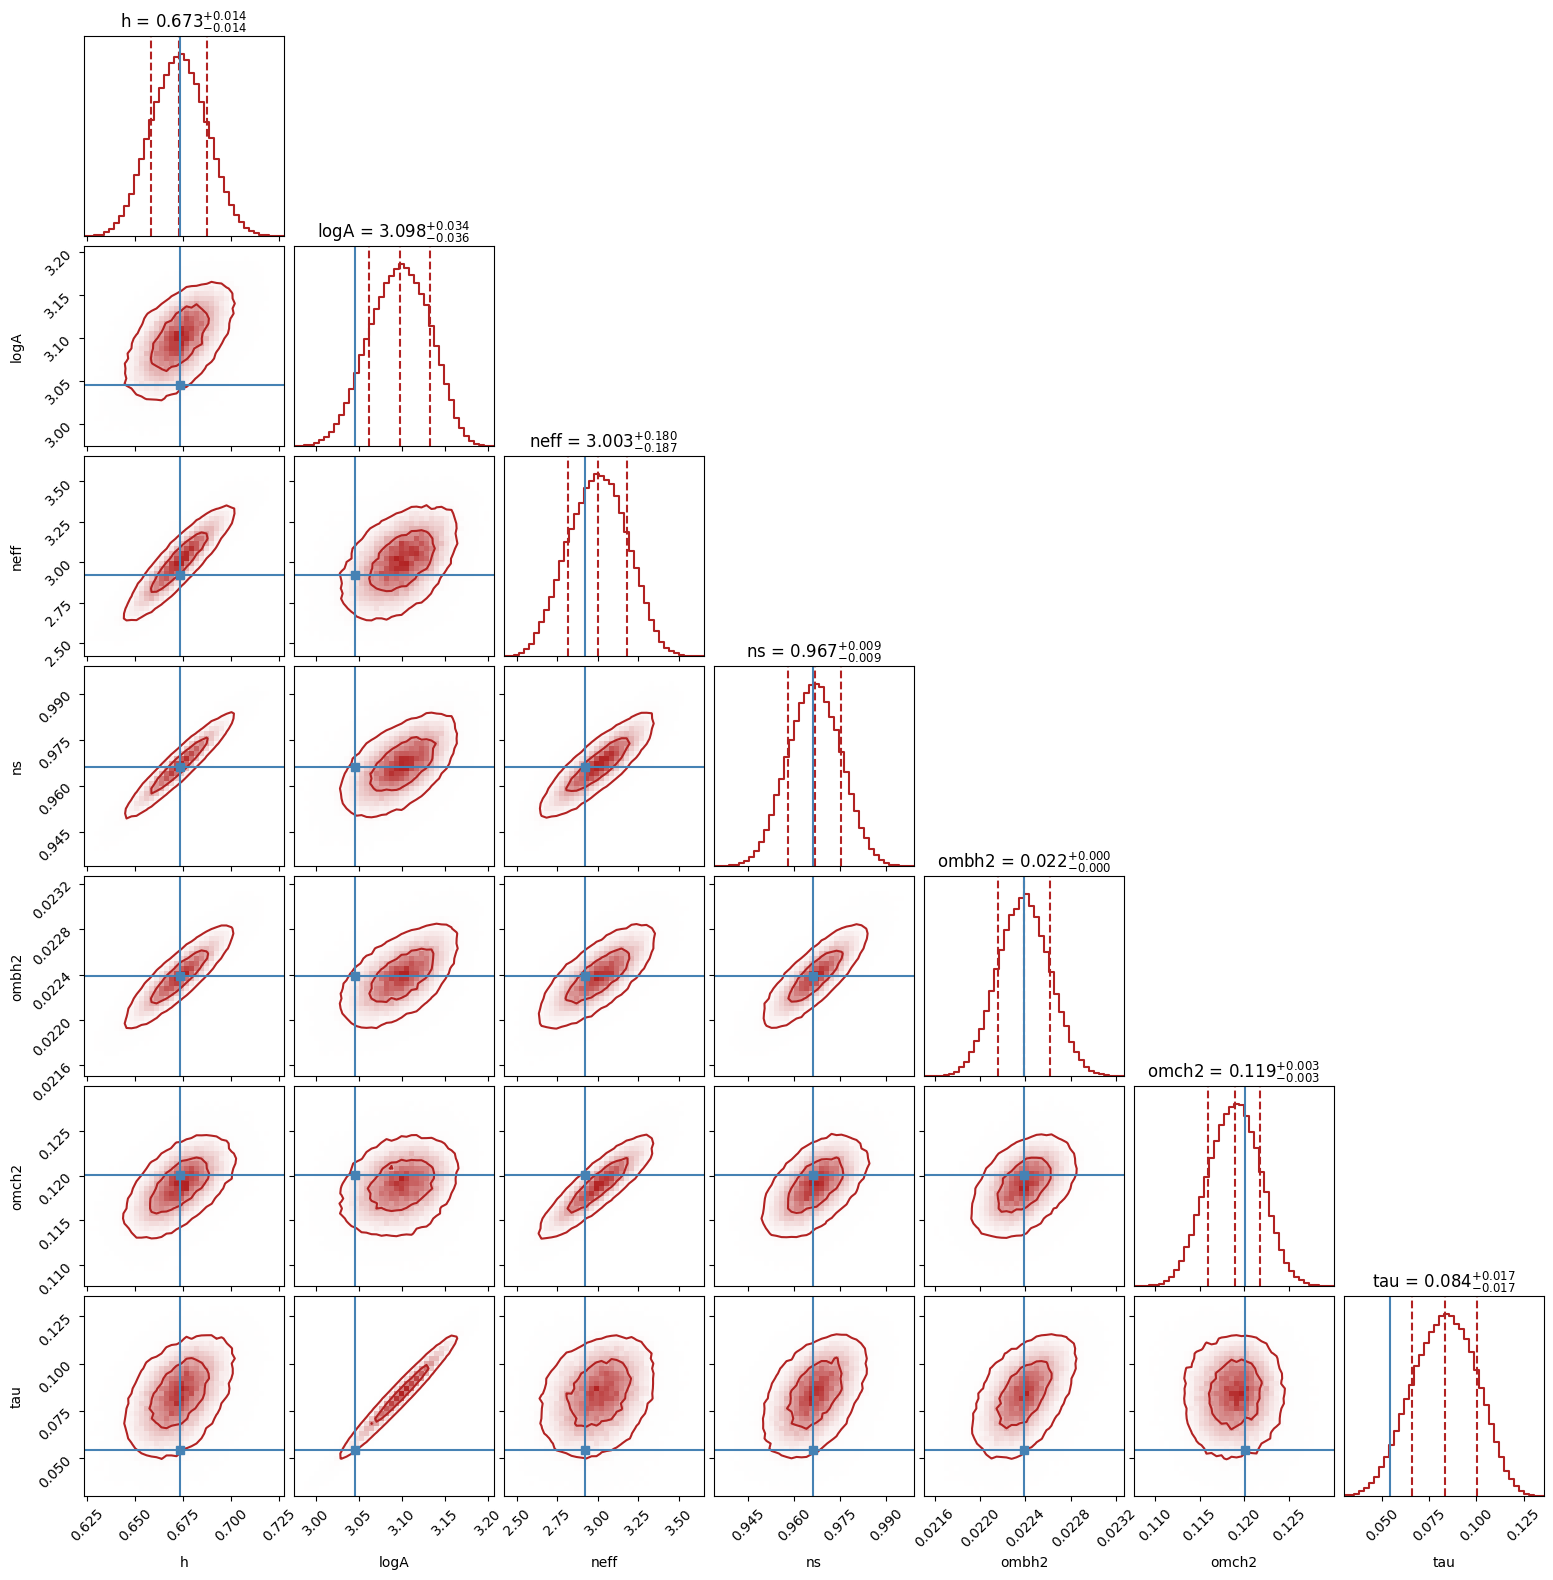

In [155]:
import corner
import arviz

# Get samples and make corner plot
num_samples = 100000

rng, _ = jax.random.split(rng)
posterior_dict = guide.sample_posterior(rng_key=rng, params=svi_results.params, sample_shape=(num_samples,))

levels =  1.0 - np.exp(-0.5 *np.array([1.0, 2.0]) ** 2)

corner_configs = {
    "smooth": 0.4,
    "smooth1d": 0.4,
    "bins": 40,
    "levels": levels,
    "quantiles": [0.16, 0.50, 0.84], 
    "title_fmt": ".3f",
    "show_titles": True,
    "plot_datapoints": False,
    "plot_density": True,
    "color": 'firebrick',
}

corner.corner(arviz.from_dict(posterior_dict), truths=params, **corner_configs);

In [147]:
arviz.summary(arviz.from_dict(posterior_dict))

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h,0.673,0.014,0.647,0.699,0.000,0.0,98191.0,98514.0,NaN
logA,3.097,0.034,3.034,3.159,0.000,0.0,99943.0,98683.0,NaN
neff,3.000,0.177,2.671,3.323,0.001,0.0,98645.0,99156.0,NaN
ns,0.967,0.008,0.951,0.982,0.000,0.0,98837.0,99133.0,NaN
ombh2,0.022,0.000,0.022,0.023,0.000,0.0,98428.0,99045.0,NaN
omch2,0.119,0.003,0.113,0.124,0.000,0.0,99128.0,99340.0,NaN
tau,0.083,0.016,0.053,0.113,0.000,0.0,100167.0,98889.0,NaN
